In [1]:
import pandas as pd
import os
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# defining end quarters dates
quarter_ends = {
    1: "04-30",
    2: "08-31",
    3: "12-31"
}

In [3]:
def calc_ret_momentum(lookback_months = 6, start_year = 2003, end_year = 2021):

    ret_df = pd.DataFrame(columns=[f"{lookback_months}monthsLB_returns"])
    std_df = pd.DataFrame(columns=[f"{lookback_months}monthsLB_std"])
    for year in range(2003, 2021):
        for quarter in range(1, 4):
            for quarter_months in range(0, 4):
                # importing quarter index constituints closing prices
                df = pd.read_csv(f"data/clean_data/{quarter}Q{year}.csv", index_col=0, parse_dates=[0])
                # defining datetime quarter end
                end_quarter_date = pd.to_datetime(f"{year}-{quarter_ends[quarter]}")
                # defining rolling month end within quarter
                end_date = end_quarter_date - relativedelta(months=4) + relativedelta(months=quarter_months)
                # applying closing price higher than 100-day moving average filter
                data = df.loc[ : , (df.iloc[-1,:] > df.iloc[-101:-1,:].mean())]
                # defining start date of rolling period
                start_date = end_date - relativedelta(months=lookback_months)
                # defining return period calculation month
                return_period = end_date + relativedelta(months=1)
                # preparing data for exponential linear regression (also dropping NaN containing columns)
                Y = np.log(data[start_date:end_date]).dropna(axis=1)
                # creating emptry dataframe for momentum calculation
                momentum_data = pd.DataFrame()
                # regression loop calculation
                for asset in Y:
                    # defining dependent variable (period lenght reshaped)
                    x = np.arange(len(Y.index)).reshape(-1, 1)
                    # instantiating regressor
                    reg = LinearRegression()
                    # fitting regressor with training data
                    reg.fit(x, Y[asset])
                    # storing coeficient and score of regression
                    coef = reg.coef_
                    score = reg.score(x, Y[asset])
                    # creating momentum indicator
                    momentum_data[asset] = score * coef
                # rearanging dataframe and sorting from higher to lower momentum indicator
                momentum_data_transposed = momentum_data.T.rename(columns={0: "ranking"}).sort_values("ranking", ascending=False)
                # selecting best 5 momentumn indicator tickers, assuring only positive values are taken into account
                return_period_tickers = momentum_data_transposed.loc[ : , momentum_data_transposed.ge(0).all()].head(5).index.to_list()
                # storing return of next month based on rolling X months top 5 momentum ticker (equal-weighted portfolio)
                return_month = (df[end_date:return_period][return_period_tickers].iloc[[0,-1]].pct_change().iloc[-1].sum())/5
                # calculating monthly std of return_period_tickers portfolio
                ## calculating returns for portfolio holding period
                ret_month = df[end_date:return_period][return_period_tickers].pct_change().dropna()
                ## defining equal-weight (5 assets, 20% weight each)
                weights = np.asarray( 5 * [0.2] )
                ## calculating covariance matrix and tranforming to monthly basis
                cov_matrix = ret_month.cov() * 30
                ## calculating std_month for 5 top momentum asset portfolio, monthly based
                std_month = np.sqrt( np.dot( weights.T, np.dot( cov_matrix, weights)))
                # storing retuns and std of the portfolio on dataframes grouped by month
                ret_df.loc[return_period.to_period("M")] = return_month
                std_df.loc[return_period.to_period("M")] = std_month
    return ret_df, std_df

In [4]:
# creating momentum and std dataframes to store data
data = pd.DataFrame()
std_data = pd.DataFrame()
# loop for range 2 to 6 months period lookback relative momentum strategies
for lbmonths in range(2, 7):
    data[f"{lbmonths}mLB_returns"], std_data[f"{lbmonths}mLB_returns"] = calc_ret_momentum(lbmonths)


In [5]:
# calculating mean monthly returns for each relative momentum strategies
round(data.mean().sort_values(ascending=False)*100, 2)

6mLB_returns    3.38
5mLB_returns    3.35
3mLB_returns    3.18
2mLB_returns    3.10
4mLB_returns    3.02
dtype: float64

In [6]:
# calculating mean standard deviation of returns for each strategy
round(std_data.mean().sort_values(ascending=False)*100, 2)

2mLB_returns    9.58
3mLB_returns    9.31
4mLB_returns    9.31
5mLB_returns    9.18
6mLB_returns    9.02
dtype: float64

In [7]:
# downloading monthly risk-free rate data from Brazilian central bank
url_bc = "http://api.bcb.gov.br/dados/serie/bcdata.sgs.4391/dados?formato=json"
cdi_df = pd.read_json(url_bc)
cdi_df["data"] = pd.to_datetime(cdi_df["data"], format="%d/%m/%Y")
cdi_df.set_index("data", inplace=True)
cdi_df.rename_axis(None, inplace=True)

In [8]:
# calculating Sharpe ratio for each relative momentum strategy
pd.DataFrame((data.values*100 - cdi_df.to_period("M")["2003-01":"2020-12"].values)/(std_data.values*100), index=data.index, columns=data.columns).mean().sort_values(ascending=False)

6mLB_returns    0.343612
3mLB_returns    0.330821
5mLB_returns    0.328549
4mLB_returns    0.295528
2mLB_returns    0.279522
dtype: float64

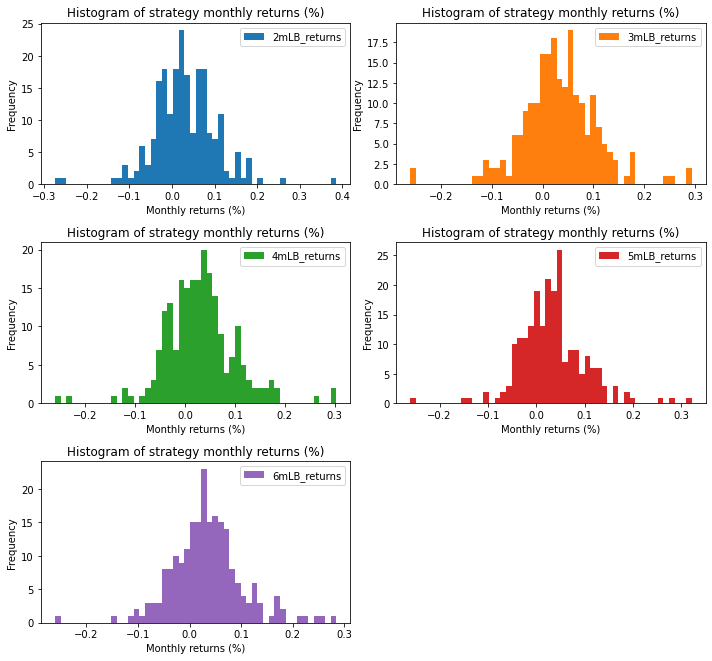

In [9]:
# plotting the histogram of monthly returns for each strategy
colors = plt.rcParams["axes.prop_cycle"]()
plt.figure(figsize=(10, 18), layout="tight")
for i, strategy in enumerate(data):
    c = next(colors)["color"]
    plt.subplot(6, 2, i + 1)
    plt.hist(x = data[strategy], bins=50, label=strategy, color=c)
    plt.xlabel("Monthly returns (%)")
    plt.ylabel("Frequency")
    plt.title("Histogram of strategy monthly returns (%)")
    plt.legend();

In [10]:
# monte-carlo method to determine probabilities of maximum drawdown in a 5-year period for each relative momentum strategy
dd_mc = {}
for strategy in data:
    max_dd = np.array([])
    for n in range(50_000):
        sim_ret = np.random.choice(data[strategy].to_numpy().reshape(-1), size = 120, replace = True)

        sim_val = (1 + sim_ret).cumprod()

        max_val = np.maximum.accumulate(sim_val)

        max_dd = np.append(max_dd, np.max((max_val - sim_val)/max_val)*100)
    dd_mc[strategy] = max_dd

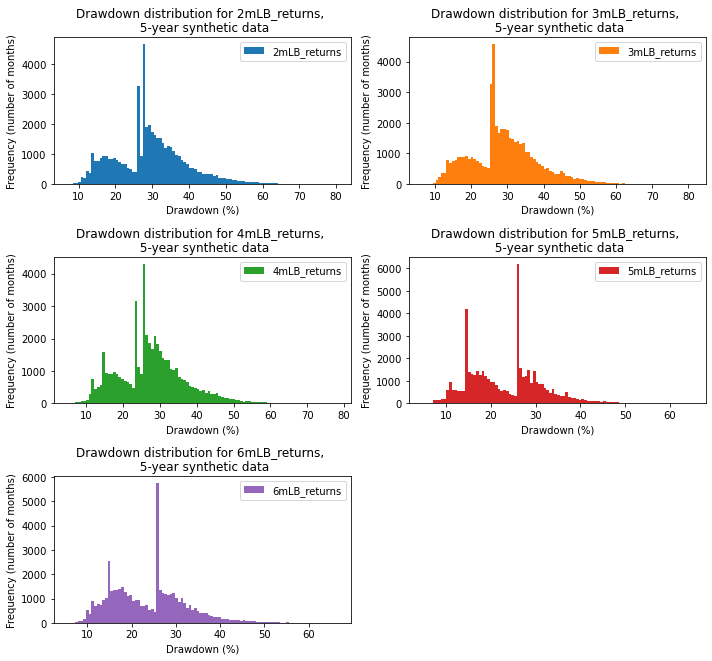

In [15]:
# plotting histogram of maximum drawdowns
colors = plt.rcParams["axes.prop_cycle"]()
plt.figure(figsize=(10, 18), layout="tight")
for i, strategy in enumerate(dd_mc):
    c = next(colors)["color"]
    plt.subplot(6, 2, i + 1)
    plt.hist(x = dd_mc[strategy], bins=100, label=strategy, color=c)
    plt.title(f"Drawdown distribution for {strategy}, \n 5-year synthetic data")
    plt.xlabel("Drawdown (%)")
    plt.ylabel("Frequency (number of months)")
    plt.legend();

In [12]:
# finding the probability of drawdown being higher than x%
round(pd.DataFrame(dd_mc).describe([.5, .75, .95]), 2).T

,count,mean,std,min,50%,75%,95%,max
2mLB_returns,50000.0,29.56,9.66,6.87,28.99,35.01,46.97,80.30
3mLB_returns,50000.0,29.07,9.22,6.48,28.23,34.23,45.88,81.00
4mLB_returns,50000.0,27.66,9.06,4.84,26.93,32.56,44.17,78.13
5mLB_returns,50000.0,23.41,8.43,4.67,23.90,28.65,37.82,64.91
6mLB_returns,50000.0,23.90,8.42,5.42,24.57,29.12,38.48,66.45
